In [24]:
import pandas as pd
import plotly.express as px

file_path_borne = '../data/raw/BornesPropres.csv'
df_borne = pd.read_csv(file_path_borne)

print("Voici les colonnes de Bornes :")
print(df_borne.columns)


file_path_population = '../data/clean/population_with_geopoint.csv'
df_population = pd.read_csv(file_path_population)
print("Voici les colonnes de Population :")
print(df_population.columns)



Voici les colonnes de Bornes :
Index(['nom_amenageur', 'contact_amenageur', 'nom_operateur',
       'contact_operateur', 'nom_enseigne', 'id_station_itinerance',
       'id_station_local', 'nom_station', 'implantation_station',
       'adresse_station', 'coordonneesXY', 'nbre_pdc', 'id_pdc_itinerance',
       'id_pdc_local', 'puissance_nominale', 'prise_type_ef', 'prise_type_2',
       'prise_type_combo_ccs', 'prise_type_chademo', 'prise_type_autre',
       'gratuit', 'paiement_acte', 'paiement_cb', 'paiement_autre',
       'tarification', 'condition_acces', 'reservation', 'horaires',
       'accessibilite_pmr', 'restriction_gabarit', 'station_deux_roues',
       'raccordement', 'date_mise_en_service', 'date_maj', 'cable_t2_attache',
       'last_modified', 'datagouv_dataset_id', 'datagouv_resource_id',
       'datagouv_organization_or_owner', 'created_at',
       'consolidated_longitude', 'consolidated_latitude',
       'consolidated_is_lon_lat_correct',
       'consolidated_is_code_i

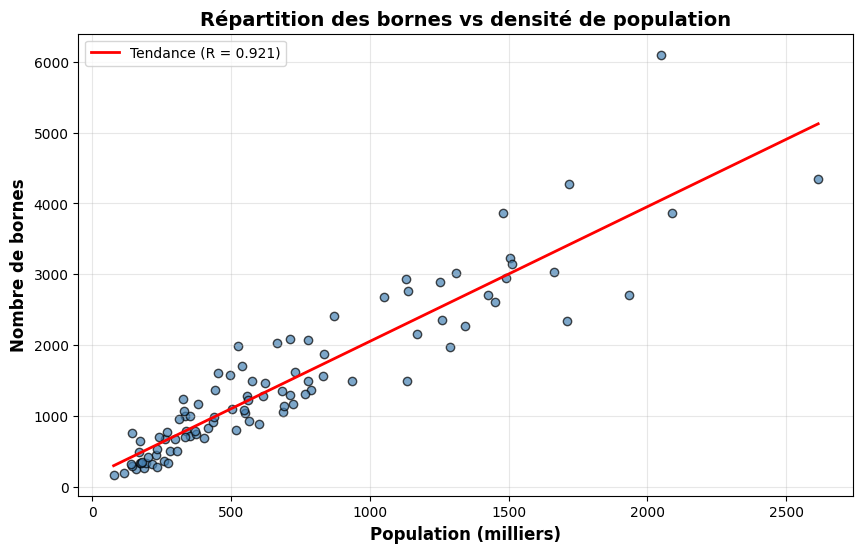


📊 Corrélation: 0.921
✅ Forte corrélation : oui, la répartition suit la densité.


In [25]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from scipy import stats

def joindre_datasets_bornes_population():
    # Chargement des données
    bornes_df = pd.read_csv("../data/raw/BornesPropres.csv")
    population_df = pd.read_csv("../data/clean/population_with_geopoint.csv")

    # --- Nettoyage des codes département ---
    def extraire_code_departement(adresse):
        if pd.isna(adresse):
            return None
        match = re.search(r'\b(\d{5})\b', str(adresse))
        if match:
            cp = match.group(1)
            if cp.startswith('97'):   # DOM
                return cp[:3]
            elif cp.startswith('20'): # Corse
                return '2A' if int(cp[2:]) < 200 else '2B'
            else:
                return cp[:2]
        return None

    bornes_df['dept_code'] = bornes_df['adresse_station'].apply(extraire_code_departement)

    # Supprime les lignes sans code
    bornes_clean = bornes_df[bornes_df['dept_code'].notna()].copy()

    # Normalisation
    bornes_clean['dept_code'] = bornes_clean['dept_code'].astype(str).str.upper()
    population_df['IdDepartement'] = population_df['IdDepartement'].astype(str).str.upper()

    # Nettoyage de la population AVANT la jointure
    population_df['Total'] = (
        population_df['Total']
        .astype(str)
        .str.replace(r'\s', '', regex=True)
        .str.replace(',', '.')
    )
    population_df['Total'] = pd.to_numeric(population_df['Total'], errors='coerce')

    # Agrégation des bornes
    bornes_aggregees = bornes_clean.groupby('dept_code').agg({
        'id_pdc_itinerance': 'count',
        'puissance_nominale': ['sum', 'mean'],
        'gratuit': lambda x: (x == True).sum(),
        'paiement_cb': lambda x: (x == True).sum()
    }).round(2)

    bornes_aggregees.columns = [
        'nb_bornes', 'puissance_totale_kw', 'puissance_moyenne_kw',
        'nb_bornes_gratuites', 'nb_bornes_cb'
    ]
    bornes_aggregees = bornes_aggregees.reset_index()

    # Jointure (outer pour garder tous les départements)
    donnees_jointes = pd.merge(
        bornes_aggregees,
        population_df,
        left_on='dept_code',
        right_on='IdDepartement',
        how='outer'
    )

    # Remplissage bornes vides par 0
    for col in ['nb_bornes', 'puissance_totale_kw', 'puissance_moyenne_kw', 'nb_bornes_gratuites', 'nb_bornes_cb']:
        donnees_jointes[col] = donnees_jointes[col].fillna(0)

    return donnees_jointes

def graph_simple_bornes_population(donnees_jointes):
    data = donnees_jointes[(donnees_jointes['Total'] > 0) & (donnees_jointes['nb_bornes'] > 0)].copy()

    if len(data) < 2:
        print(f"⚠️ Pas assez de données valides pour tracer un graphique. Lignes valides: {len(data)}")
        return

    correlation, p_value = stats.pearsonr(data['Total'], data['nb_bornes'])

    plt.figure(figsize=(10, 6))
    plt.scatter(data['Total']/1000, data['nb_bornes'], alpha=0.7, color='steelblue', edgecolors='black')

    z = np.polyfit(data['Total'], data['nb_bornes'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(data['Total'].min(), data['Total'].max(), 100)
    plt.plot(x_trend/1000, p(x_trend), 'red', linewidth=2,
             label=f'Tendance (R = {correlation:.3f})')

    plt.xlabel('Population (milliers)', fontsize=12, fontweight='bold')
    plt.ylabel('Nombre de bornes', fontsize=12, fontweight='bold')
    plt.title('Répartition des bornes vs densité de population', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"\n📊 Corrélation: {correlation:.3f}")
    if correlation > 0.7:
        print("✅ Forte corrélation : oui, la répartition suit la densité.")
    elif correlation > 0.5:
        print("🟧 Corrélation modérée : partiellement.")
    else:
        print("❌ Faible corrélation : non.")

if __name__ == "__main__":
    try:
        donnees_finales = joindre_datasets_bornes_population()
        graph_simple_bornes_population(donnees_finales)
    except FileNotFoundError as e:
        print(f"Erreur: Fichier non trouvé - {e}")
